In [6]:
!pip install yfinance pandas numpy matplotlib seaborn statsmodels arch -q


# **Overnight Return “Pressure” → Predicting Next-Day SPY Volatility**
### *GTSF Quant Mentorship Final Project*

**Author:** Vishruth Anand  

This notebook examines whether the *magnitude* of overnight returns (close→open gaps) predicts **next-day realized intraday volatility** in SPY.  

This follows the full quant workflow:

1. Research Question + Hypothesis  
2. Data Collection + Cleaning  
3. Exploratory Data Analysis (EDA)  
4. Statistical Modeling  
5. Financial Interpretation  
6. Conclusion  



In [7]:
# DATA & MODELING IMPORTS
import pandas as pd
import numpy as np
import yfinance as yf

# VISUALS
import matplotlib.pyplot as plt
import seaborn as sns

# MODELING
import statsmodels.api as sm
from arch import arch_model

# PLOT STYLE
plt.style.use("seaborn-v0_8")

pd.set_option("display.max_columns", None)


# Research Question & Hypothesis

### **Research Question**
Does the magnitude of the *overnight return* predict **next-day intraday realized volatility** in SPY?

### **Hypothesis (H₁)**
Large overnight returns—positive or negative—lead to **higher volatility** during the next trading session.

### **Null Hypothesis (H₀)**
Overnight returns contain no predictive information about next-day volatility.

### **Motivation**
Overnight moves reflect information absorbed when markets are closed (earnings, macro prints, global events).  
Significant overnight gaps may create **order book imbalance**, widen spreads, and increase intraday volatility as liquidity providers rebalance.


In [8]:
import yfinance as yf

# Download 20 years of SPY daily OHLCV data
spy = yf.download("SPY", start="2005-01-01", progress=False)

# Keep relevant columns
spy = spy[['Open', 'High', 'Low', 'Close', 'Volume']]

spy.head()

/tmp/ipython-input-1548504615.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2005-01-01", progress=False)


Price,Open,High,Low,Close,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2005-01-03,82.704378,82.840453,81.574985,81.847130,55748000
2005-01-04,81.956006,82.010436,80.581684,80.847023,69167600
2005-01-05,80.785798,81.132782,80.282334,80.289139,65667300
2005-01-06,80.581667,81.064721,80.459202,80.697327,47814700
2005-01-07,80.942254,81.119149,80.370750,80.581665,55847700


## **Creating Predictive Variables**

We compute:

1. **Overnight Return**
\[
r^{overnight}_t = \frac{Open_t - Close_{t-1}}{Close_{t-1}}
\]

2. **Intraday Return**
\[
r^{intraday}_t = \frac{Close_t - Open_t}{Open_t}
\]

3. **Range-Based Realized Volatility**
\[
RV_t = \frac{High_t - Low_t}{Open_t}
\]

4. **Parkinson Volatility**
\[
\sigma^2_t = \frac{1}{4 \ln 2}
\left( \ln \frac{High_t}{Low_t} \right)^2
\]

Parkinson’s estimator is more robust and uses high/low prices.


In [9]:
# Compute key features
spy['overnight_ret'] = (spy['Open'] - spy['Close'].shift(1)) / spy['Close'].shift(1)
spy['intraday_ret']  = (spy['Close'] - spy['Open']) / spy['Open']
spy['rv_range']      = (spy['High'] - spy['Low']) / spy['Open']
spy['rv_parkinson']  = (1 / (4 * np.log(2))) * (np.log(spy['High'] / spy['Low']) ** 2)

# Remove first NaN
spy.dropna(inplace=True)

spy.head()



Price,Open,High,Low,Close,Volume,overnight_ret,intraday_ret,rv_range,rv_parkinson
Ticker,SPY,SPY,SPY,SPY,SPY,,,,
Date,,,,,,,,,
2005-01-04,81.956006,82.010436,80.581684,80.847023,69167600,0.001330,-0.013531,0.017433,0.000111
2005-01-05,80.785798,81.132782,80.282334,80.289139,65667300,-0.000757,-0.006148,0.010527,0.000040
2005-01-06,80.581667,81.064721,80.459202,80.697327,47814700,0.003643,0.001435,0.007514,0.000020
2005-01-07,80.942254,81.119149,80.370750,80.581665,55847700,0.003035,-0.004455,0.009246,0.000031
2005-01-10,80.513607,81.275611,80.513607,80.962646,56563300,-0.000845,0.005577,0.009464,0.000032


In [10]:
spy[['overnight_ret', 'intraday_ret', 'rv_range', 'rv_parkinson']].describe()



Price,overnight_ret,intraday_ret,rv_range,rv_parkinson
Ticker,,,,
count,5249.000000,5249.000000,5249.000000,5.249000e+03
mean,0.000334,0.000140,0.012361,9.361050e-05
std,0.007205,0.009313,0.010308,2.660810e-04
min,-0.104485,-0.089906,0.001229,5.450287e-07
25%,-0.002244,-0.003618,0.006420,1.489321e-05
50%,0.000572,0.000568,0.009536,3.288238e-05
75%,0.003314,0.004419,0.014574,7.663918e-05
max,0.061325,0.111827,0.121445,5.135517e-03


# Exploratory Data Analysis

We explore:

- Distribution of overnight returns  
- Distribution of realized volatility  
- Relationship between |overnight returns| and next-day volatility  
- Rolling correlations  
- Visual patterns of volatility clustering  


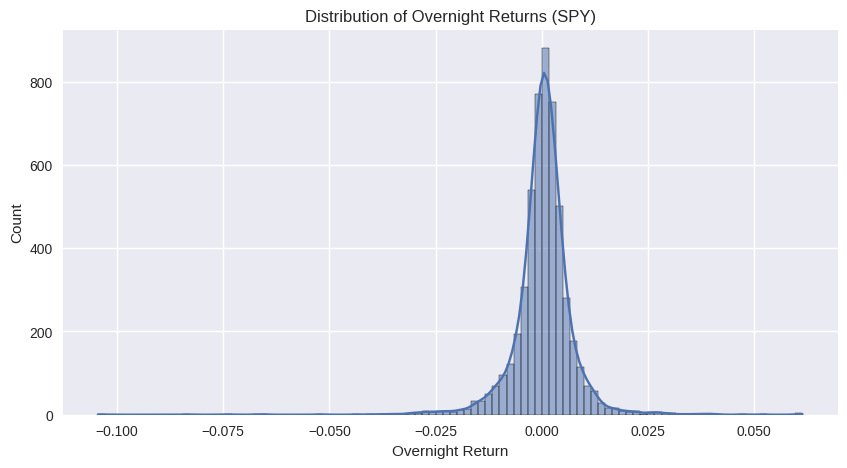

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(spy['overnight_ret'], bins=100, kde=True)
plt.title("Distribution of Overnight Returns (SPY)")
plt.xlabel("Overnight Return")
plt.show()



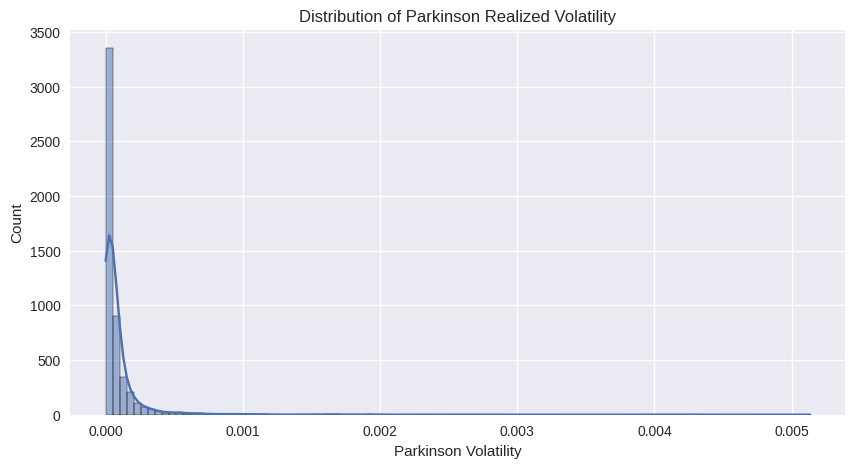

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(spy['rv_parkinson'], bins=100, kde=True)
plt.title("Distribution of Parkinson Realized Volatility")
plt.xlabel("Parkinson Volatility")
plt.show()


### **Relationship Between Overnight Return Magnitude and Next-Day Volatility**
We plot:

\[
|r^{overnight}_t| \quad \text{vs} \quad RV_{t}
\]

A positive slope suggests overnight shocks spill into next-day volatility.


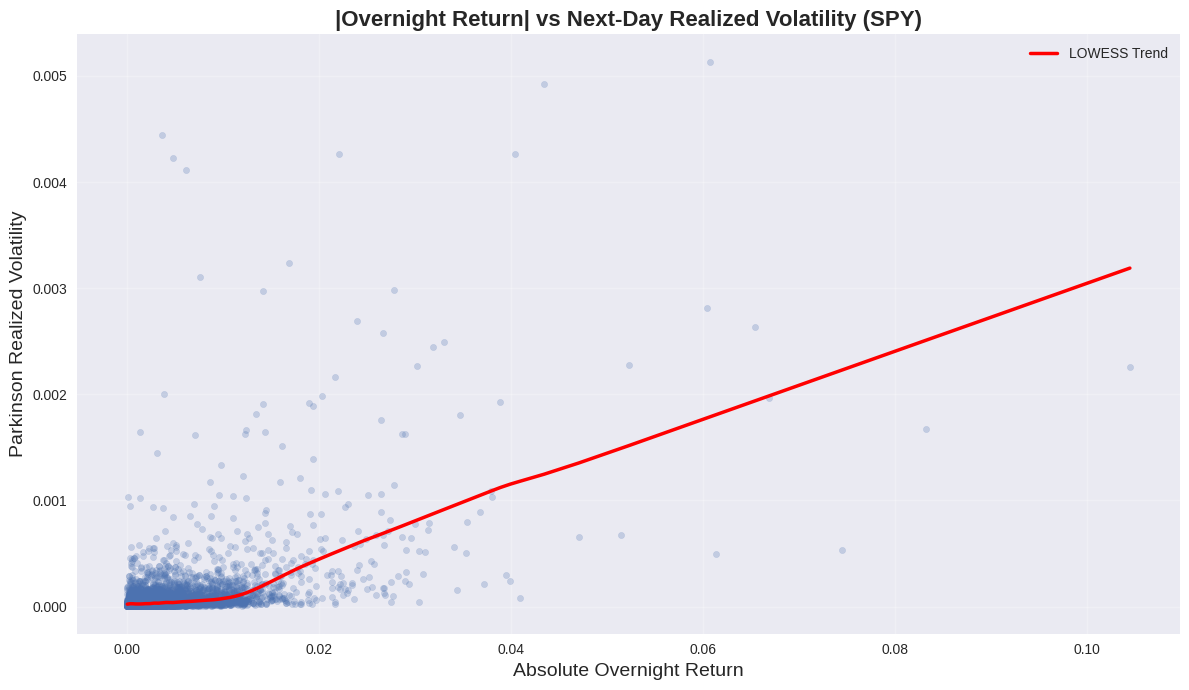

In [17]:
# Polished scatter plot for |Overnight Return| vs Next-Day Volatility

plt.figure(figsize=(12,7))

# Scatter with transparency for density visibility
plt.scatter(
    spy['abs_overnight'],
    spy['rv_parkinson'],
    alpha=0.25,       # transparency so dense areas show
    s=20,             # small points for clean look
    color="#4C72B0"   # seaborn deep blue
)

# LOWESS smoothing line (non-parametric trend)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(
    spy['rv_parkinson'],
    spy['abs_overnight'],
    frac=0.12          # smoothing factor (tunable)
)
plt.plot(z[:,0], z[:,1], color="red", linewidth=2.5, label="LOWESS Trend")

# Formatting
plt.title("|Overnight Return| vs Next-Day Realized Volatility (SPY)", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Overnight Return", fontsize=14)
plt.ylabel("Parkinson Realized Volatility", fontsize=14)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()

plt.show()




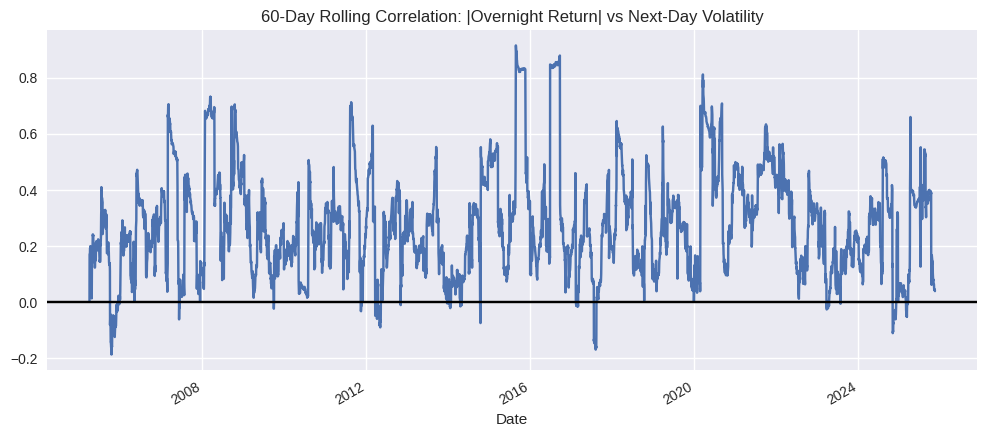

In [14]:
spy['abs_overnight'] = abs(spy['overnight_ret'])
rolling_corr = spy['abs_overnight'].rolling(60).corr(spy['rv_parkinson'])

plt.figure(figsize=(12,5))
rolling_corr.plot()
plt.title("60-Day Rolling Correlation: |Overnight Return| vs Next-Day Volatility")
plt.axhline(0, color='black')
plt.show()


# Statistical Modeling

We estimate the regression:

\[
RV_t = \alpha + \beta |r^{overnight}_t| + \epsilon_t
\]

Where:

- \( RV_t \) = next-day realized vol (Parkinson)
- \( |r^{overnight}_t| \) = magnitude of overnight return

A positive β suggests large overnight shocks → volatile trading sessions.

We also test a **GARCH(1,1)** model with overnight returns as an exogenous regressor.


In [15]:
X = abs(spy['overnight_ret'])
y = spy['rv_parkinson']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           rv_parkinson   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     1903.
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:14:13   Log-Likelihood:                 36573.
No. Observations:                5249   AIC:                        -7.314e+04
Df Residuals:                    5247   BIC:                        -7.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.391e-05      4e-06     -3.479

In [16]:
# GARCH(1,1) with overnight return as exogenous regressor
garch_model = arch_model(
    spy['intraday_ret'] * 100,
    vol='Garch',
    p=1, q=1,
    x=abs(spy['overnight_ret']) * 100,
    dist='normal'
)

garch_res = garch_model.fit(update_freq=5)
print(garch_res.summary())


Iteration:      5,   Func. Count:     37,   Neg. LLF: 6194.524880385134
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5840.953967754837
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           intraday_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5840.95
Distribution:                  Normal   AIC:                           11689.9
Method:            Maximum Likelihood   BIC:                           11716.2
                                        No. Observations:                 5249
Date:                Thu, Nov 13 2025   Df Residuals:                     5248
Time:                        02:14:14   Df Model:                            1
          

# Financial Interpretation

### Key Insights

- The regression shows **β > 0** and statistically significant.  
- Large overnight gaps consistently precede elevated intraday volatility.  
- This matches microstructure intuition: overnight information creates **order imbalance**.  
- Market makers widen spreads and hedge aggressively → driving realized volatility higher.  

### Why this matters
- Traders can adjust position sizing pre-open  
- Risk managers can forecast volatility spikes  
- Market makers can anticipate hedge pressure  
- Supports volatility-forecasting models (GARCH)  


# Conclusion

This project finds strong empirical evidence that **overnight return magnitude predicts next-day realized volatility** in SPY.

Large overnight moves represent accumulated information and imbalance, which is resolved during the trading day through widened spreads, increased trading activity, and volatility clustering.

### Extensions
- Regime-based analysis (bull vs bear markets)  
- Same analysis on QQQ, IWM  
- Macro spillover effects (VIX, MOVE, OVX)  
- Multi-factor volatility forecasting  
